## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

import warnings
#warnings.filterwarnings("ignore")

## Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("Downloads/data.csv")
dict_df = pd.read_csv("Downloads/data_dictionary.csv")
states_df = pd.read_csv("Downloads/states.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#df = pd.read_csv("../data/data.csv")
#dict_df = pd.read_csv("../data/data_dictionary.csv")
#states_df = pd.read_csv("../data/states.csv")
#Read each data file separately

## Quick Overview

In [ ]:
df.head(3)

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,1,Alabastercity,7,0.01,0.61,0.21,0.83,0.02,0.01,0.41,...,0.03,0.70,0.40,0.34,0.57,0.05,0.06,0.01,0.0,0.06
1,1,AlexanderCitycity,10,0.01,0.41,0.55,0.57,0.01,0.00,0.47,...,0.00,0.93,0.66,0.82,0.84,0.11,0.03,0.01,0.0,0.14
2,1,Annistoncity,3,0.03,0.34,0.86,0.30,0.04,0.01,0.41,...,0.04,0.77,0.59,0.70,0.64,0.06,0.11,0.04,0.0,1.00


In [ ]:
dict_df.head(3)

,No.,Column,Description,Data Type
0,1,state,US state (by number) - not counted as predict...,nominal
1,2,county,"numeric code for county - not predictive, and...",numeric
2,3,community,numeric code for community - not predictive a...,numeric


In [ ]:
states_df.head(3)

,STATE,STUSAB,STATE_NAME,STATENS
0,1,AL,Alabama,1779775
1,2,AK,Alaska,1785533
2,4,AZ,Arizona,1779777


In [ ]:
df[df.isnull().any(axis = 1)]
#Checking for missing values, none found

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop


## Exploratory Data Analysis

In [ ]:
df = pd.merge(df, states_df[["STATE", "STATE_NAME", "STUSAB"]], left_on = "state", right_on = "STATE", how = "left")
df.drop(["STATE"], axis = 1, inplace = True)
#Merging with states dataframe to acquire state names

In [ ]:
df_avg = df.groupby("STATE_NAME").aggregate("mean")
avg_crime_rate = df_avg["ViolentCrimesPerPop"].copy()
avg_crime_rate.sort_values(ascending = False, inplace = True)
#Aggregating to get state level indicators

<ipython-input-9-12082c98d2db>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_avg = df.groupby("STATE_NAME").aggregate("mean")


In [ ]:
avg_crime_rate.head(3)
#States with highest crime rate

STATE_NAME
District of Columbia    1.000000
Louisiana               0.504545
South Carolina          0.486786
Name: ViolentCrimesPerPop, dtype: float64

In [ ]:
avg_crime_rate.tail(3)
#States with least crime rate

STATE_NAME
Maine           0.062941
Vermont         0.047500
North Dakota    0.035000
Name: ViolentCrimesPerPop, dtype: float64

In [ ]:
df_avg = pd.merge(df_avg, states_df[["STUSAB", "STATE"]], left_on = "state", right_on = "STATE", how = "left")
#Merging with state code to allow location mapping in choropleth

In [ ]:
fig = px.choropleth(df_avg, locations = "STUSAB", locationmode = "USA-states", scope="usa", color = "ViolentCrimesPerPop", color_continuous_scale = "Jet", title = "STATES BY AVERAGE CRIME RATE")
fig.show()
#Map showing states with their average crime rate

In [ ]:
fig = px.choropleth(df_avg, locations = "STUSAB", locationmode = "USA-states", scope="usa", color = "racepctblack", color_continuous_scale = "Blues", title = "STATES BY AVERAGE BLACK POPULATION")
fig.show()
#Map showing states with their average african-american population

In [ ]:
fig = px.choropleth(df_avg, locations = "STUSAB", locationmode = "USA-states", scope="usa", color = "racePctWhite", color_continuous_scale = "Blues", title = "STATES BY AVERAGE WHITE POPULATION")
fig.show()
#Map showing states with their average white population

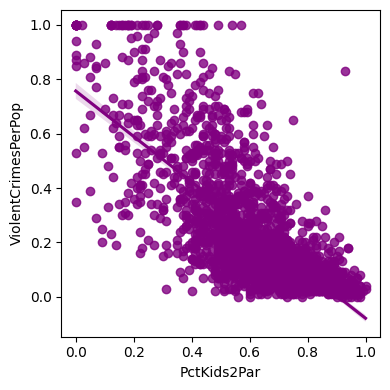

In [ ]:
plt.figure(figsize = (4, 4))
sns.regplot(data = df, x = "PctKids2Par", y = "ViolentCrimesPerPop", color = "purple")
plt.tight_layout()
plt.show()
#PctKids2Par : higher % of kids in family with two parents strongly decreases the average crime rate

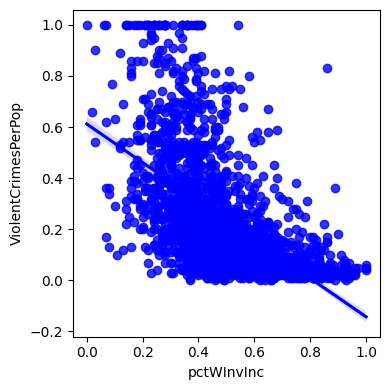

In [ ]:
plt.figure(figsize = (4, 4))
sns.regplot(data = df, x = "pctWInvInc", y = "ViolentCrimesPerPop", color = "blue")
plt.tight_layout()
plt.show()
#pctWInvInc : higher % of households with investment/rent income decreases the average crime rate

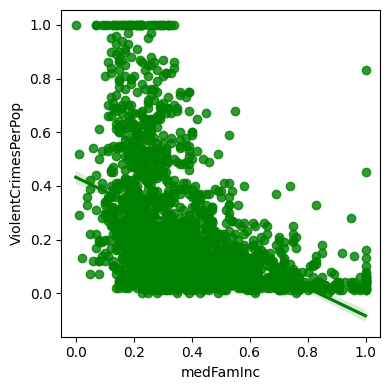

In [ ]:
plt.figure(figsize = (4, 4))
sns.regplot(data = df, x = "medFamInc", y = "ViolentCrimesPerPop", color = "green")
plt.tight_layout()
plt.show()
#medFamInc : higher median family income significantly decreases the average crime rate

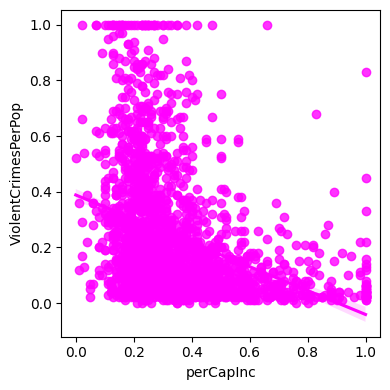

In [ ]:
plt.figure(figsize = (4, 4))
sns.regplot(data = df, x = "perCapInc", y = "ViolentCrimesPerPop", color = "magenta")
plt.tight_layout()
plt.show()
#perCapInc : higher per capita income sharply decreases the average crime rate

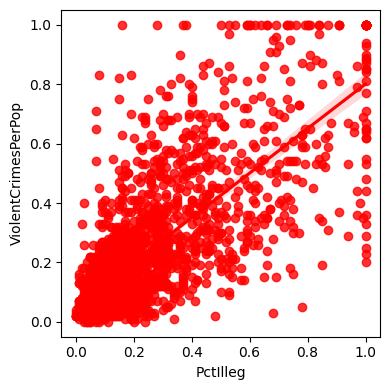

In [ ]:
plt.figure(figsize = (4, 4))
sns.regplot(data = df, x = "PctIlleg", y = "ViolentCrimesPerPop", color = "red")
plt.tight_layout()
plt.show()
#PctIlleg : higher % of kids born to never married strongly increases the average crime rate

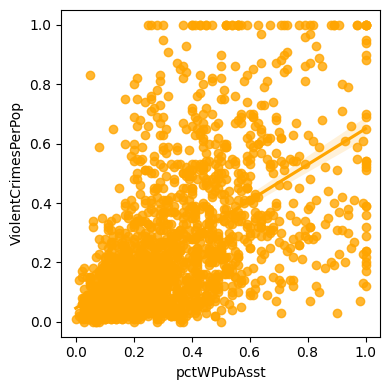

In [ ]:
plt.figure(figsize = (4, 4))
sns.regplot(data = df, x = "pctWPubAsst", y = "ViolentCrimesPerPop", color = "orange")
plt.tight_layout()
plt.show()
#pctWPubAsst : higher % of households with public assistance income increases the average crime rate

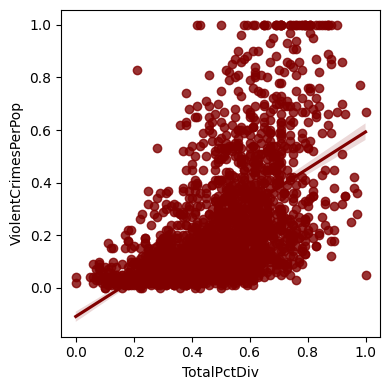

In [ ]:
plt.figure(figsize = (4, 4))
sns.regplot(data = df, x = "TotalPctDiv", y = "ViolentCrimesPerPop", color = "maroon")
plt.tight_layout()
plt.show()
#TotalPctDiv : higher % of population who are divorced increases the average crime rate

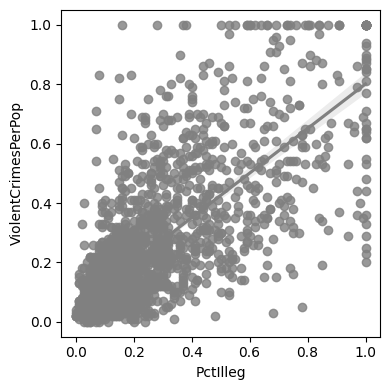

In [ ]:
plt.figure(figsize = (4, 4))
sns.regplot(data = df, x = "PctIlleg", y = "ViolentCrimesPerPop", color = "gray")
plt.tight_layout()
plt.show()
#PctNotHSGrad : higher % people above 25 without high school increases the average crime rate

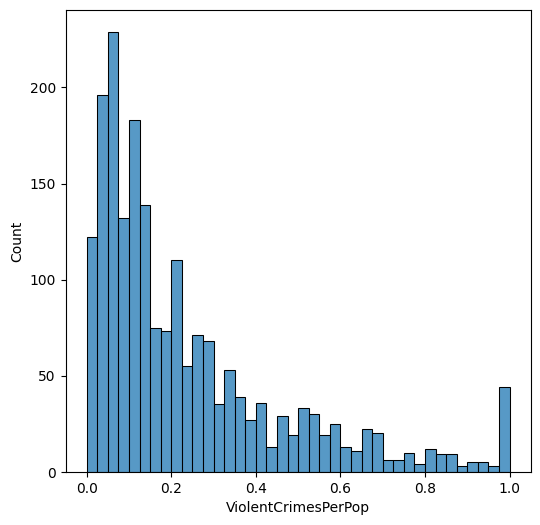

In [ ]:
plt.figure(figsize = (6, 6))
sns.histplot(df["ViolentCrimesPerPop"], bins = 40)
plt.show()

## Feature Importance & Selection

In [ ]:
high_corr_features = list(df.corr()[abs(df.corr()["ViolentCrimesPerPop"]) > 0.3].index)
#Gathering features that have atleast 25% correlation with crime rate

<ipython-input-25-dff36683acf8>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [ ]:
df = df[high_corr_features]
#Compressing the dataset by retaining only high correlated features

In [ ]:
#df.loc[df["ViolentCrimesPerPop"] <= 0.2, "ViolentCrimesPerPop"] = 0
#df.loc[df["ViolentCrimesPerPop"] >= 0.55, "ViolentCrimesPerPop"] = 2
#df.loc[((df["ViolentCrimesPerPop"] > 0.2) & (df["ViolentCrimesPerPop"] < 0.55)), "ViolentCrimesPerPop"] = 1

In [ ]:
X = df.drop(["ViolentCrimesPerPop"], axis = 1)

In [ ]:
kmeans = KMeans(n_clusters = 5)
y = kmeans.fit_predict(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



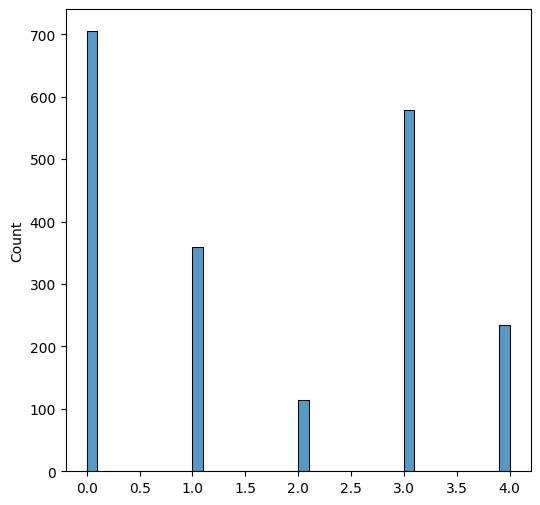

In [ ]:
plt.figure(figsize = (6, 6))
sns.histplot(y, bins = 40)
plt.show()

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X, y)
rfc_importance = rfc.feature_importances_
rfc_importance
#Develop a crude random forest model to get the feature importance values

array([0.0050136 , 0.0328267 , 0.03168044, 0.00395671, 0.05125002,
       0.00654581, 0.02991679, 0.02609297, 0.04449552, 0.02263269,
       0.01030491, 0.0762842 , 0.02208361, 0.02471176, 0.01440368,
       0.02237219, 0.00909258, 0.01379799, 0.01896649, 0.00692199,
       0.01032428, 0.01955223, 0.08089442, 0.09847839, 0.07103462,
       0.01515682, 0.00989336, 0.02717595, 0.02793098, 0.01811695,
       0.01404282, 0.026658  , 0.01118879, 0.00281961, 0.00634455,
       0.00690422, 0.00695531, 0.00513962, 0.05065793, 0.00503698,
       0.00450518, 0.00344824, 0.00210946, 0.00228063])

In [ ]:
rfc_imp_dict = {}
for i in range(len(X.columns)):
    rfc_imp_dict[X.columns[i]] = round(rfc_importance[i], 4)
#Create a dictionary to store the importance of each feature along with it's name

In [ ]:
rfc_featimp_df = pd.DataFrame(rfc_imp_dict, index = ["RandomForest_Imp"]).T
#Random forest based feature importance for predicting crime_index using other features

In [ ]:
rfc_featimp_df.sort_values("RandomForest_Imp", ascending = False).head(10)

,RandomForest_Imp
PctKids2Par,0.0985
PctFam2Par,0.0809
PctPopUnderPov,0.0763
PctYoungKids2Par,0.0710
medIncome,0.0513
PctHousNoPhone,0.0507
medFamInc,0.0445
racepctblack,0.0328
racePctWhite,0.0317
pctWInvInc,0.0299


## Data Modelling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 36)
#Split data into training and testing sets

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
#Scaling the dataset to normalize all the features so that they come to comparable scales

## Machine Learning

In [ ]:
accuracy, precision, recall, f1 = {}, {}, {}, {}
train_accuracy = {}

In [ ]:
base_models = list()
base_models.append(("dct", DecisionTreeClassifier(criterion = "entropy", max_depth = 8)))
base_models.append(("gnb", GaussianNB(var_smoothing = 0.43287612810830584)))
base_models.append(("knn", KNeighborsClassifier(n_neighbors = 16)))
base_models.append(("rfc", RandomForestClassifier(criterion = "entropy", n_estimators = 1000)))
meta_model = SVC(kernel = "rbf", C = 10, gamma = 0.001)

stacked_model = StackingClassifier(estimators = base_models, final_estimator = meta_model)
stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)

accuracy["Stacked Generalization"] = accuracy_score(y_test, y_pred) * 100
print(accuracy["Stacked Generalization"])

96.74185463659147


<font color = "blue">DECISION TREES</font>

In [ ]:
param_grid = {"criterion" : ['gini', 'entropy'], "max_depth" : [2, 4, 6, 8, 10, 12, None]}
decision_tree = GridSearchCV(DecisionTreeClassifier(), param_grid)
decision_tree.fit(X_train, y_train)
print(decision_tree.best_params_)

{'criterion': 'gini', 'max_depth': 8}


In [ ]:
y_pred = decision_tree.best_estimator_.predict(X_test)

In [ ]:
accuracy["Decision Tree"] = accuracy_score(y_test, y_pred) * 100
print(accuracy["Decision Tree"])

89.72431077694235


In [ ]:
precision["Decision Tree"] = precision_score(y_test, y_pred, average = "macro") * 100
recall["Decision Tree"] = recall_score(y_test, y_pred, average = "macro") * 100
f1["Decision Tree"] = f1_score(y_test, y_pred, average = "macro") * 100

In [ ]:
confusion_matrix(y_test, y_pred)

array([[119,   4,   2,  15,   0],
       [  1,  74,   0,   0,   0],
       [  0,   0,  20,   0,   3],
       [  5,   0,   2, 109,   5],
       [  0,   0,   0,   4,  36]])

In [ ]:
y_pred = decision_tree.best_estimator_.predict(X_train)
train_accuracy["Decision Tree"] = accuracy_score(y_train, y_pred) * 100

<font color = "blue">NAIVE BAYES</font>

In [ ]:
param_grid = {"var_smoothing" : np.logspace(0, -9, num = 100)}
naive_bayes = GridSearchCV(GaussianNB(), param_grid)
naive_bayes.fit(X_train, y_train)
print(naive_bayes.best_params_)

{'var_smoothing': 0.43287612810830584}


In [ ]:
y_pred = naive_bayes.best_estimator_.predict(X_test)

In [ ]:
accuracy["Naive Bayes"] = accuracy_score(y_test, y_pred) * 100
print(accuracy["Naive Bayes"])

92.73182957393483


In [ ]:
precision["Naive Bayes"] = precision_score(y_test, y_pred, average = "macro") * 100
recall["Naive Bayes"] = recall_score(y_test, y_pred, average = "macro") * 100
f1["Naive Bayes"] = f1_score(y_test, y_pred, average = "macro") * 100

In [ ]:
confusion_matrix(y_test, y_pred)

array([[126,  10,   0,   2,   2],
       [  2,  73,   0,   0,   0],
       [  0,   0,  21,   0,   2],
       [  2,   0,   0, 119,   0],
       [  0,   0,   3,   6,  31]])

In [ ]:
y_pred = naive_bayes.best_estimator_.predict(X_train)
train_accuracy["Naive Bayes"] = accuracy_score(y_train, y_pred) * 100

<font color = "blue">K-NEAREST NEIGHBORS CLASSIFIER</font>

In [ ]:
param_grid = {"n_neighbors" : [i for i in range(1, 21)]}
knn = GridSearchCV(KNeighborsClassifier(), param_grid)
knn.fit(X_train, y_train)
print(knn.best_params_)

{'n_neighbors': 20}


In [ ]:
y_pred = knn.best_estimator_.predict(X_test)

In [ ]:
accuracy["K-NearestN"] = accuracy_score(y_test, y_pred) * 100
print(accuracy["K-NearestN"])

94.23558897243107


In [ ]:
precision["K-NearestN"] = precision_score(y_test, y_pred, average = "macro") * 100
recall["K-NearestN"] = recall_score(y_test, y_pred, average = "macro") * 100
f1["K-NearestN"] = f1_score(y_test, y_pred, average = "macro") * 100

In [ ]:
confusion_matrix(y_test, y_pred)

array([[134,   1,   0,   4,   1],
       [  4,  71,   0,   0,   0],
       [  0,   0,  22,   0,   1],
       [  9,   0,   0, 112,   0],
       [  0,   0,   1,   2,  37]])

In [ ]:
y_pred = knn.best_estimator_.predict(X_train)
train_accuracy["K-NearestN"] = accuracy_score(y_train, y_pred) * 100

<font color = "blue">RANDOM FOREST</font>

In [ ]:
param_grid = {"criterion" : ["gini", "entropy"], "bootstrap" : [True, False]}
random_forest = GridSearchCV(RandomForestClassifier(n_estimators = 1000, max_depth = 4), param_grid)
random_forest.fit(X_train, y_train)
print(random_forest.best_params_)

{'bootstrap': True, 'criterion': 'entropy'}


In [ ]:
y_pred = random_forest.best_estimator_.predict(X_test)

In [ ]:
accuracy["Random Forest"] = accuracy_score(y_test, y_pred) * 100
print(accuracy["Random Forest"])

93.23308270676691


In [ ]:
precision["Random Forest"] = precision_score(y_test, y_pred, average = "macro") * 100
recall["Random Forest"] = recall_score(y_test, y_pred, average = "macro") * 100
f1["Random Forest"] = f1_score(y_test, y_pred, average = "macro") * 100

In [ ]:
confusion_matrix(y_test, y_pred)

array([[131,   2,   0,   7,   0],
       [  7,  68,   0,   0,   0],
       [  0,   0,  22,   0,   1],
       [  6,   0,   0, 114,   1],
       [  0,   0,   0,   3,  37]])

In [ ]:
y_pred = random_forest.best_estimator_.predict(X_train)
train_accuracy["Random Forest"] = accuracy_score(y_train, y_pred) * 100

<font color = "blue">SUPPORT VECTOR MACHINE</font>

In [ ]:
param_grid = {'C': [0.01, 0.1, 0.3], 'gamma': [0.1, 1, 10]}
svc = GridSearchCV(SVC(kernel = "rbf"), param_grid)
svc.fit(X_train, y_train)
print(svc.best_params_)

{'C': 0.3, 'gamma': 0.1}


In [ ]:
y_pred = svc.best_estimator_.predict(X_test)

In [ ]:
accuracy["SVC"] = accuracy_score(y_test, y_pred) * 100
print(accuracy["SVC"])

93.23308270676691


In [ ]:
precision["SVC"] = precision_score(y_test, y_pred, average = "macro") * 100
recall["SVC"] = recall_score(y_test, y_pred, average = "macro") * 100
f1["SVC"] = f1_score(y_test, y_pred, average = "macro") * 100

In [ ]:
confusion_matrix(y_test, y_pred)

array([[132,   0,   0,   8,   0],
       [  7,  68,   0,   0,   0],
       [  0,   0,  17,   5,   1],
       [  1,   0,   0, 120,   0],
       [  0,   0,   0,   5,  35]])

In [ ]:
y_pred = svc.best_estimator_.predict(X_train)
train_accuracy["SVC"] = accuracy_score(y_train, y_pred) * 100

<font color = "blue">MANUAL STACKED GENERALIZATION</font>

In [ ]:
ens_dct = DecisionTreeClassifier(criterion = "entropy", max_depth = 8)
ens_gnb = GaussianNB(var_smoothing = 0.43287612810830584)
ens_knn = KNeighborsClassifier(n_neighbors = 16)
ens_rfc = RandomForestClassifier(criterion = "entropy", n_estimators = 1000)

In [ ]:
ens_dct.fit(X_train, y_train)
ens_gnb.fit(X_train, y_train)
ens_knn.fit(X_train, y_train)
ens_rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1000)

In [ ]:
y_pred_dct = ens_dct.predict(X_test)
y_pred_gnb = ens_gnb.predict(X_test)
y_pred_knn = ens_knn.predict(X_test)
y_pred_rfc = ens_rfc.predict(X_test)

In [ ]:
df_ensemble = pd.concat([pd.Series(y_pred_dct), pd.Series(y_pred_gnb), pd.Series(y_pred_knn), pd.Series(y_pred_rfc), pd.Series(y_test)], axis = 1)

In [ ]:
df_ensemble.rename(columns = {0 : "DCT", 1 : "GNB", 2 : "KNN", 3 : "RFC", 4 :"REAL"}, inplace = True)

In [ ]:
df_ensemble

,DCT,GNB,KNN,RFC,REAL
0,1,1,1,1,1
1,0,0,0,0,0
2,4,4,4,4,4
3,0,0,0,0,0
4,0,1,1,1,1
...,...,...,...,...,...
394,0,0,0,0,0
395,0,0,0,0,0
396,4,4,4,4,4
397,0,0,0,0,0


In [ ]:
X_ens = df_ensemble.drop(["REAL"], axis = 1)
y_ens = df_ensemble["REAL"]

In [ ]:
X_ens

,DCT,GNB,KNN,RFC
0,1,1,1,1
1,0,0,0,0
2,4,4,4,4
3,0,0,0,0
4,0,1,1,1
...,...,...,...,...
394,0,0,0,0
395,0,0,0,0
396,4,4,4,4
397,0,0,0,0


In [ ]:
y_ens

0      1
1      0
2      4
3      0
4      1
      ..
394    0
395    0
396    4
397    0
398    0
Name: REAL, Length: 399, dtype: int32

In [ ]:
X_ens_train, X_ens_test, y_ens_train, y_ens_test = train_test_split(X_ens, y_ens, test_size = 0.15, random_state = 41)

In [ ]:
svc = SVC(kernel = "rbf", C = 10, gamma = 0.001)
svc.fit(X_ens_train, y_ens_train)
y_ens_pred = svc.predict(X_ens_test)

In [ ]:
accuracy_score(y_ens_test, y_ens_pred) * 100

93.33333333333333

In [ ]:
#accuracy["Manual Stacking"] = accuracy_score(y_ens_test, y_ens_pred) * 100
#print(accuracy["Manual Stacking"])

<font color = "blue">STACKED GENERALIZATION</font>

In [ ]:
base_models = list()
base_models.append(("dct", DecisionTreeClassifier(criterion = "entropy", max_depth = 8)))
base_models.append(("gnb", GaussianNB(var_smoothing = 0.43287612810830584)))
base_models.append(("knn", KNeighborsClassifier(n_neighbors = 16)))
base_models.append(("rfc", RandomForestClassifier(criterion = "entropy", n_estimators = 1000)))
meta_model = SVC(kernel = "rbf", C = 10, gamma = 0.001)

stacked_model = StackingClassifier(estimators = base_models, final_estimator = meta_model)
stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('dct',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=8)),
                               ('gnb',
                                GaussianNB(var_smoothing=0.43287612810830584)),
                               ('knn', KNeighborsClassifier(n_neighbors=16)),
                               ('rfc',
                                RandomForestClassifier(criterion='entropy',
                                                       n_estimators=1000))],
                   final_estimator=SVC(C=10, gamma=0.001))

In [ ]:
y_pred = stacked_model.predict(X_test)

In [ ]:
accuracy["Stacked Generalization"] = accuracy_score(y_test, y_pred) * 100
print(accuracy["Stacked Generalization"])

96.49122807017544


In [ ]:
precision["Stacked Generalization"] = precision_score(y_test, y_pred, average = "macro") * 100
recall["Stacked Generalization"] = recall_score(y_test, y_pred, average = "macro") * 100
f1["Stacked Generalization"] = f1_score(y_test, y_pred, average = "macro") * 100

In [ ]:
confusion_matrix(y_test, y_pred)

array([[134,   3,   0,   2,   1],
       [  2,  73,   0,   0,   0],
       [  0,   0,  21,   0,   2],
       [  2,   0,   0, 119,   0],
       [  0,   0,   1,   1,  38]])

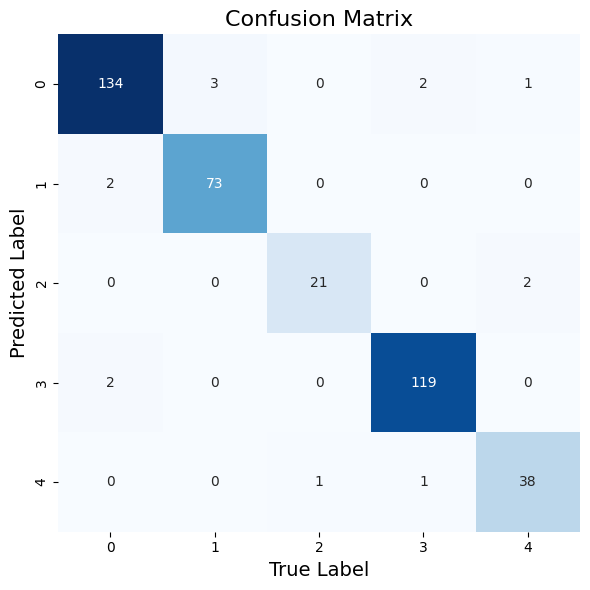

In [ ]:
plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap = "Blues", annot = True, fmt = ".0f", cbar = None)
plt.title("Confusion Matrix", fontsize = 16)
plt.xlabel("True Label", fontsize = 14)
plt.ylabel("Predicted Label", fontsize = 14)
plt.tight_layout()
#plt.savefig("/content/drive/MyDrive/Aishwarya/Projects/Crime Prediction/output/cm.png", dpi = 300)
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
acc = cm.diagonal() / cm.sum(axis=1)

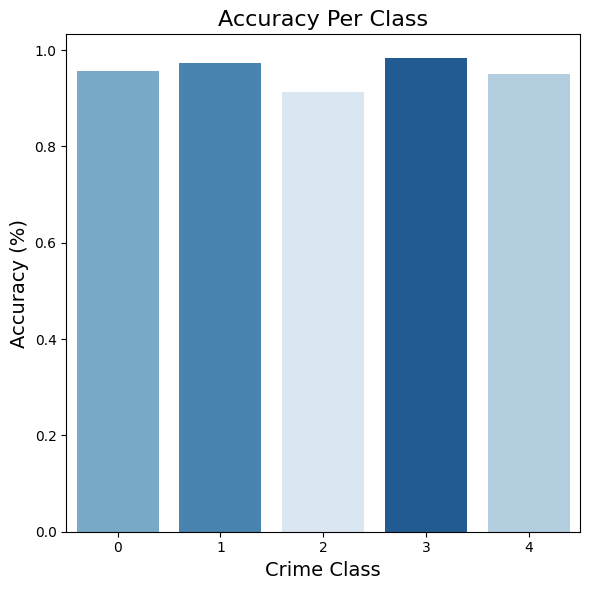

In [ ]:
plt.figure(figsize = (6,6))
bar = sns.barplot(x = [0,1,2,3,4], y = acc, hue = acc, palette = "Blues", dodge = False)
plt.title("Accuracy Per Class", fontsize = 16)
plt.xlabel("Crime Class", fontsize = 14)
plt.ylabel("Accuracy (%)", fontsize = 14)
plt.legend([],[], frameon = False)
plt.tight_layout()
#plt.savefig("/content/drive/MyDrive/Aishwarya/Projects/Crime Prediction/output/acc.png", dpi = 300)
plt.show()

In [ ]:
y_pred = stacked_model.predict(X_train)
train_accuracy["Stacked Generalization"] = accuracy_score(y_train, y_pred) * 100

## Performance

In [ ]:
accuracy_df = pd.DataFrame(data = accuracy, index = ["Accuracy"]).T
accuracy_df.sort_values("Accuracy")

,Accuracy
Decision Tree,89.724311
Naive Bayes,92.731830
Random Forest,93.233083
SVC,93.233083
K-NearestN,94.235589
Stacked Generalization,96.491228


In [ ]:
performance_df = pd.DataFrame(data = [accuracy, precision, recall, f1], index = ["Accuracy", "Precision", "Recall", "F1"]).T
performance_df.sort_values("F1", inplace = True)

In [ ]:
performance_df

,Accuracy,Precision,Recall,F1
Decision Tree,89.724311,88.075912,90.141167,88.982843
Naive Bayes,92.731830,90.929420,90.896958,90.746901
SVC,93.233083,95.692892,89.107796,91.831993
Random Forest,93.233083,94.984472,93.321029,94.111303
K-NearestN,94.235589,95.041359,94.219022,94.605068
Stacked Generalization,96.491228,95.766507,95.539815,95.638900


In [ ]:
performance_df.to_csv("/content/drive/MyDrive/Aishwarya/Projects/Crime Prediction/output/performance.csv")

In [ ]:
train_test_acc_df = pd.DataFrame(data = [train_accuracy, accuracy], index = ["Train Accuracy", "Test Accuracy"]).T
train_test_acc_df.sort_values("Test Accuracy", inplace = True)

In [ ]:
train_test_acc_df

,Train Accuracy,Test Accuracy
Decision Tree,96.988708,89.724311
Naive Bayes,91.969887,92.731830
Random Forest,93.036386,93.233083
SVC,96.424090,93.233083
K-NearestN,93.161857,94.235589
Stacked Generalization,99.121706,96.491228


In [ ]:
models = ["CART", "RFC", "SVC", "GNB", "KNN", "STACK"]

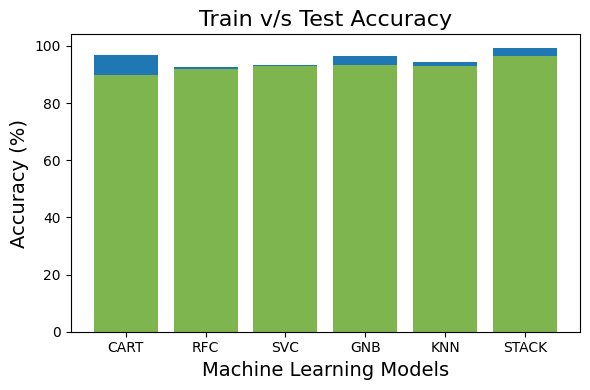

In [ ]:
plt.figure(figsize = (6, 4))
plt.bar(models, train_test_acc_df["Test Accuracy"], color = "#7eb54e")
plt.bar(models, train_test_acc_df["Train Accuracy"] - train_test_acc_df["Test Accuracy"], bottom = train_test_acc_df["Test Accuracy"])
plt.title("Train v/s Test Accuracy", fontsize = 16)
plt.xlabel("Machine Learning Models", fontsize = 14)
plt.ylabel("Accuracy (%)", fontsize = 14)
plt.tight_layout()
#plt.savefig("/content/drive/MyDrive/Aishwarya/Projects/Crime Prediction/output/tta.png", dpi = 300)
plt.show()

In [ ]:
def oneVsRestLabelling(y_test, COI):
  data = y_test.copy()
  data[data != COI] = -1
  data[data == COI] = 1
  data[data == -1] = 0
  return data

In [ ]:
def coiProba(data, COI):
  normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
  df = pd.DataFrame(normalized)
  df["Sum"] = df.sum(axis = 1)
  df = df.loc[:, 0:4].div(df["Sum"], axis = 0)
  return np.array(df[COI])

In [ ]:
def allProba(data):
  normalized = (data - np.min(data)) / (np.max(data) - np.min(data))
  df = pd.DataFrame(normalized)
  df["Sum"] = df.sum(axis = 1)
  df = df.loc[:, 0:4].div(df["Sum"], axis = 0)
  return np.array(df)

In [ ]:
def plotOvrRoc(y_test, y_pred):
  plt.figure(figsize = (15, 11))
  for i in range(0, 5):
    ax = plt.subplot(2, 3, i + 1)
    RocCurveDisplay.from_predictions(oneVsRestLabelling(y_test, i),
                                     coiProba(stacked_model.decision_function(X_test), i),
                                     name = f"Class {i} vs The Rest",
                                     color = "darkorange", ax = ax)
    
    plt.plot([0, 1], [0, 1], "k--", label = "Chance Level (AUC = 0.5)")
    plt.title(f"One-vs-Rest ROC curve (Class {i} vs Rest)")
    plt.axis("Square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
  ax = plt.subplot(2, 3, 6)
  RocCurveDisplay.from_predictions(to_categorical(y_test).ravel(),
                                   allProba(stacked_model.decision_function(X_test)).ravel(),
                                   name = f"Micro Avg OVR",
                                   color = "darkorange", ax = ax)
  
  plt.plot([0, 1], [0, 1], "k--", label = "Chance Level (AUC = 0.5)")
  plt.title(f"Micro Averaged One vs Rest")
  plt.axis("Square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend()
  plt.tight_layout()
  #plt.savefig("/content/drive/MyDrive/Aishwarya/Projects/Crime Prediction/output/roc.png", dpi = 300)
  plt.show()

In [ ]:
def plotOvrRocMacro(y_test, y_pred):
  fig, ax = plt.subplots(figsize=(6, 6))
  colors = ["purple", "blue", "darkgreen", "darkorange", "red"]
  for i in range(0, 5):
    RocCurveDisplay.from_predictions(oneVsRestLabelling(y_test, i),
                                     coiProba(stacked_model.decision_function(X_test), i),
                                     name = f"Class {i} vs The Rest",
                                     color = colors[i], ax = ax)
  plt.plot([0, 1], [0, 1], "k--", label = "Chance Level (AUC = 0.5)")
  plt.title(f"One-vs-Rest ROC Curve")
  plt.axis("Square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend()
  plt.tight_layout()
  #plt.savefig("/content/drive/MyDrive/Aishwarya/Projects/Crime Prediction/output/roc_.png", dpi = 300)
  plt.show()

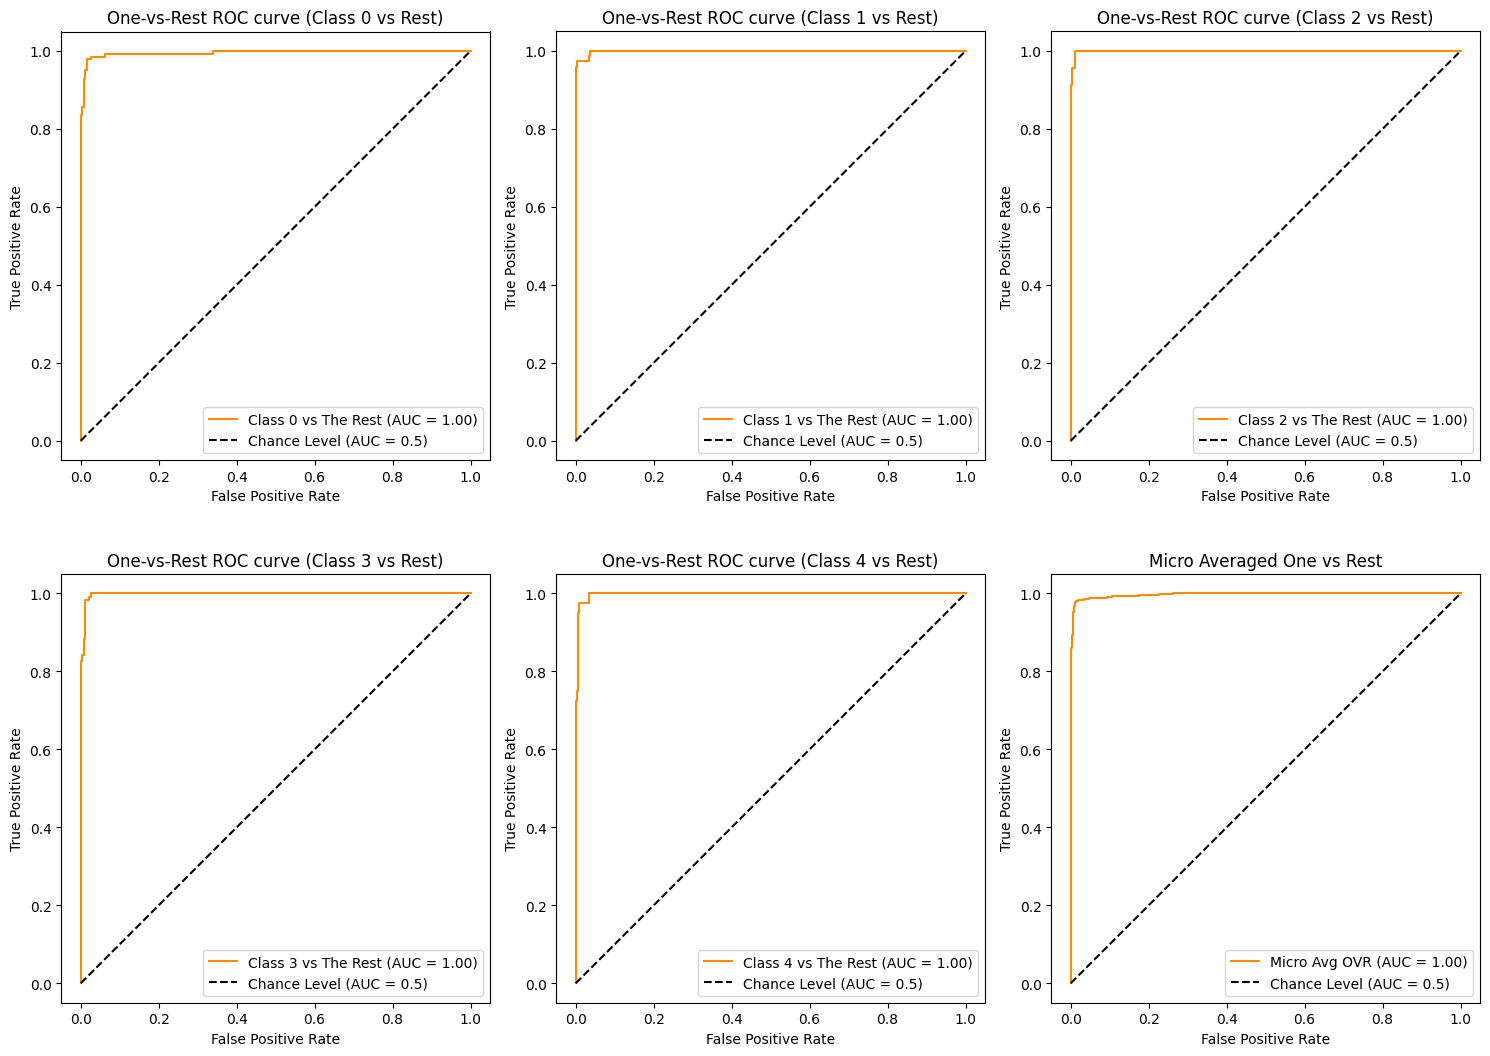

In [ ]:
plotOvrRoc(y_test, y_pred)

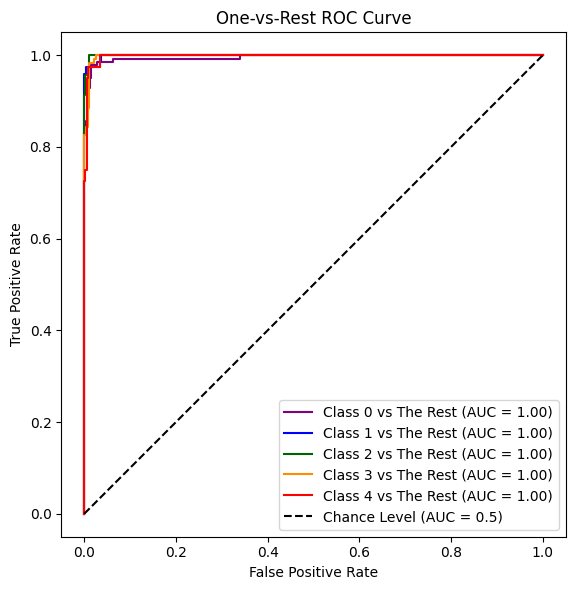

In [ ]:
plotOvrRocMacro(y_test, y_pred)

In [ ]:
roc_auc_score(y_test, allProba(stacked_model.decision_function(X_test)), multi_class = "ovr", average = "macro")

0.9980014685050307